## A note book to review and summarize QC metrics for HRApop v1.0

## Install and import libraries

In [33]:
%pip install requests pandas seaborn duckdb matplotlib

import os
import zipfile
import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


## Load data

In [34]:
import os
import zipfile


def unzip_if_needed(zip_path: str, extract_dir: str) -> None:
    """Unzip a ZIP file only if it hasn't been extracted yet."""
    if os.path.exists(extract_dir) and os.listdir(extract_dir):
        print(f"⚙️ Already unzipped — skipping extraction: {extract_dir}")
        return

    print(f"📦 Extracting {zip_path} ...")
    os.makedirs(extract_dir, exist_ok=True)
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"✅ Files extracted to: {extract_dir}")



zip_path = "data/hra-pop-v1.0-qc.zip"
extract_dir = "data/unzipped"
unzip_if_needed(zip_path, extract_dir)

⚙️ Already unzipped — skipping extraction: data/unzipped


In [35]:
"""
D CREATE TABLE qc AS SELECT * FROM read_json('qc/*/qc_results/qc_summary.json', union_by_name = true, filename = true );
D .schema qc
CREATE TABLE qc(input_file VARCHAR, total_cells BIGINT, low_quality_cells BIGINT, percent_low_quality DOUBLE, mean_pct_counts_mt DOUBLE, mean_pct_counts_ribo DOUBLE, thresholds STRUCT(min_genes BIGINT, max_genes BIGINT, max_mt DOUBLE, min_ribo JSON, mt_prefix VARCHAR, ribo_prefixes VARCHAR[]), files STRUCT(qc_per_cell_csv VARCHAR, qc_summary_csv VARCHAR), filename VARCHAR);
"""

"\nD CREATE TABLE qc AS SELECT * FROM read_json('qc/*/qc_results/qc_summary.json', union_by_name = true, filename = true );\nD .schema qc\nCREATE TABLE qc(input_file VARCHAR, total_cells BIGINT, low_quality_cells BIGINT, percent_low_quality DOUBLE, mean_pct_counts_mt DOUBLE, mean_pct_counts_ribo DOUBLE, thresholds STRUCT(min_genes BIGINT, max_genes BIGINT, max_mt DOUBLE, min_ribo JSON, mt_prefix VARCHAR, ribo_prefixes VARCHAR[]), files STRUCT(qc_per_cell_csv VARCHAR, qc_summary_csv VARCHAR), filename VARCHAR);\n"

In [36]:
data_dir = "data/unzipped"

# 1. Create the table from JSON files
query = f"""
CREATE OR REPLACE TABLE qc AS
WITH qc_data AS (
    SELECT
        *,
        regexp_extract(filename, '.*/qc/([^/]+)/qc_results/.*', 1) AS folder_name
    FROM read_json('{data_dir}/qc/*/qc_results/qc_summary.json',
                   union_by_name = true,
                   filename = true)
),
datasets AS (
    SELECT
        regexp_extract(filename, '.*/qc/([^/]+)/dataset.json', 1) AS folder_name,
        dataset_id
    FROM read_json('{data_dir}/qc/*/dataset.json',
                   union_by_name = true,
                   filename = true)
)
SELECT 
    q.*,
    d.dataset_id
FROM qc_data q
LEFT JOIN datasets d USING (folder_name);
"""

# Run the query
duckdb.sql(query)

# ✅ Load the table into a Pandas DataFrame
df_qc = duckdb.sql("SELECT * FROM qc").df()

# 2. Export results to CSV
duckdb.sql(
    f"""
COPY qc TO '{data_dir}/cell-instances.csv.gz' (FORMAT CSV, HEADER, COMPRESSION GZIP);
"""
)

# 3. Optionally show a preview
print("\n🔍 Preview:")
duckdb.sql("SELECT * FROM qc LIMIT 10;").show()

# 4. Verify DataFrame content
print("\n📊 DataFrame loaded with shape:", df_qc.shape)
print(df_qc.head())


🔍 Preview:
┌────────────────────────────────────────────────────────────────┬─────────────┬───────────────────┬─────────────────────┬────────────────────┬──────────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬──────────────────────────────────────────────────────────────────────────────────────────────┬─────────────────────────────────────────────────────────────┬─────────────────┬───────────────────────────────────────────────────────────────────────────────────┐
│                           input_file                           │ total_cells │ low_quality_cells │ percent_low_quality │ mean_pct_counts_mt │ mean_pct_counts_ribo │                                                      thresholds                                                       │                                            files                                             │                          filename                           

In [37]:
df_qc

,input_file,total_cells,low_quality_cells,percent_low_quality,mean_pct_counts_mt,mean_pct_counts_ribo,thresholds,files,filename,folder_name,dataset_id
0,/var/lib/cwl/stg556eb54e-beaf-4c22-8292-aed297...,100891,53763,53.29,0.0,0.0,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/HBM234.VNGB.747/qc_results/qc...,HBM234.VNGB.747,https://entity.api.hubmapconsortium.org/entiti...
1,/var/lib/cwl/stgedd76d4f-10a5-4ddd-bd61-d4db8f...,5929,95,1.60,0.0,0.0,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/HBM248.VZRB.728/qc_results/qc...,HBM248.VZRB.728,https://entity.api.hubmapconsortium.org/entiti...
2,/var/lib/cwl/stgeab1a4e5-4285-4e2f-a67f-99367a...,6000,158,2.63,0.0,0.0,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/HBM265.NQCH.947/qc_results/qc...,HBM265.NQCH.947,https://entity.api.hubmapconsortium.org/entiti...
3,/var/lib/cwl/stg1ff681e0-ffd7-4126-a0d9-753103...,52534,49020,93.31,0.0,0.0,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/HBM296.KZXD.676/qc_results/qc...,HBM296.KZXD.676,https://entity.api.hubmapconsortium.org/entiti...
4,/var/lib/cwl/stge8e8c6b3-d20b-4369-ac09-b95b94...,89168,73597,82.54,0.0,0.0,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/HBM339.FPMK.994/qc_results/qc...,HBM339.FPMK.994,https://entity.api.hubmapconsortium.org/entiti...
...,...,...,...,...,...,...,...,...,...,...,...
553,/var/lib/cwl/stge6d80b61-d96f-4794-a4d5-6a0a4a...,3629,0,0.00,0.0,0.0,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/https___api.cellxgene.cziscie...,https___api.cellxgene.cziscience.com_dp_v1_col...,https://api.cellxgene.cziscience.com/dp/v1/col...
554,/var/lib/cwl/stg09c146a9-3f2f-4330-a865-ac6f65...,2300,0,0.00,0.0,0.0,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/https___api.cellxgene.cziscie...,https___api.cellxgene.cziscience.com_dp_v1_col...,https://api.cellxgene.cziscience.com/dp/v1/col...
555,/var/lib/cwl/stgbb86861f-6292-4d41-a13b-59b99b...,13479,177,1.31,0.0,0.0,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/https___api.cellxgene.cziscie...,https___api.cellxgene.cziscience.com_dp_v1_col...,https://api.cellxgene.cziscience.com/dp/v1/col...
556,/var/lib/cwl/stg02a91b00-8c02-4e23-854d-c8c004...,3348,14,0.42,0.0,0.0,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/https___api.cellxgene.cziscie...,https___api.cellxgene.cziscience.com_dp_v1_col...,https://api.cellxgene.cziscience.com/dp/v1/col...


## Preprocess before visualizing

In [41]:
# Load Sankey CSV to add organ name
try:
    df_sankey = pd.read_csv(
        "https://raw.githubusercontent.com/x-atlas-consortia/hra-pop/refs/heads/main/output-data/v1.0/reports/universe-ad-hoc/sankey.csv"
    )[["organ_name", "dataset_id","portal"]]

except:
    df_sankey = pd.read_csv("data/sankey.csv")[["organ_name", "dataset_id","portal"]]

# Workaround if GitHub gives 429 error:
# https://cdn.jsdelivr.net/gh/<user>/<repo>@<branch>/<filepath>

df_sankey

/var/folders/x7/ttglg94d4g500ypbdkw3__nw0000gq/T/ipykernel_40964/2221412276.py:3: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sankey = pd.read_csv(


,organ_name,dataset_id,portal
0,small intestine,hhttps://api.cellxgene.cziscience.com/dp/v1/co...,HCA
1,right kidney,http://dx.doi.org/10.1681/ASN.2016091027#Donor...,KPMP
2,right kidney,http://dx.doi.org/10.1681/ASN.2016091027#Donor...,KPMP
3,right kidney,http://dx.doi.org/10.1681/ASN.2016091027#Donor...,KPMP
4,mesenteric lymph node,http://purl.org/ccf/1.5/omap-1#Donor1_TissueBl...,HRA
...,...,...,...
22189,heart,https://sparc.science/datasets/390/version/1?d...,SPARC
22190,heart,https://sparc.science/datasets/390/version/1?d...,SPARC
22191,heart,https://sparc.science/datasets/390/version/1?d...,SPARC
22192,left kidney,https://zenodo.org/records/7653239#Donor1_Tiss...,KPMP


In [42]:
df_merged = df_qc.merge(df_sankey, on="dataset_id", how="inner")

## Get counts

In [49]:
mean_scores = df_merged.groupby("organ_name")["percent_low_quality"].mean()
mean_scores

organ_name
Set of lactiferous glands in left breast      1.920000
Set of lactiferous glands in right breast     0.000000
heart                                        15.932342
large intestine                              17.052553
left kidney                                  31.854022
left ureter                                   0.973077
liver                                         3.780000
male reproductive system                      1.340000
pancreas                                      3.155000
respiratory system                           19.932717
right kidney                                 53.426040
right ureter                                  2.323333
skin of body                                  0.084286
small intestine                              13.673043
spleen                                       19.894000
thymus                                        0.702500
urinary bladder                               2.230000
Name: percent_low_quality, dtype: float64

## Visualize

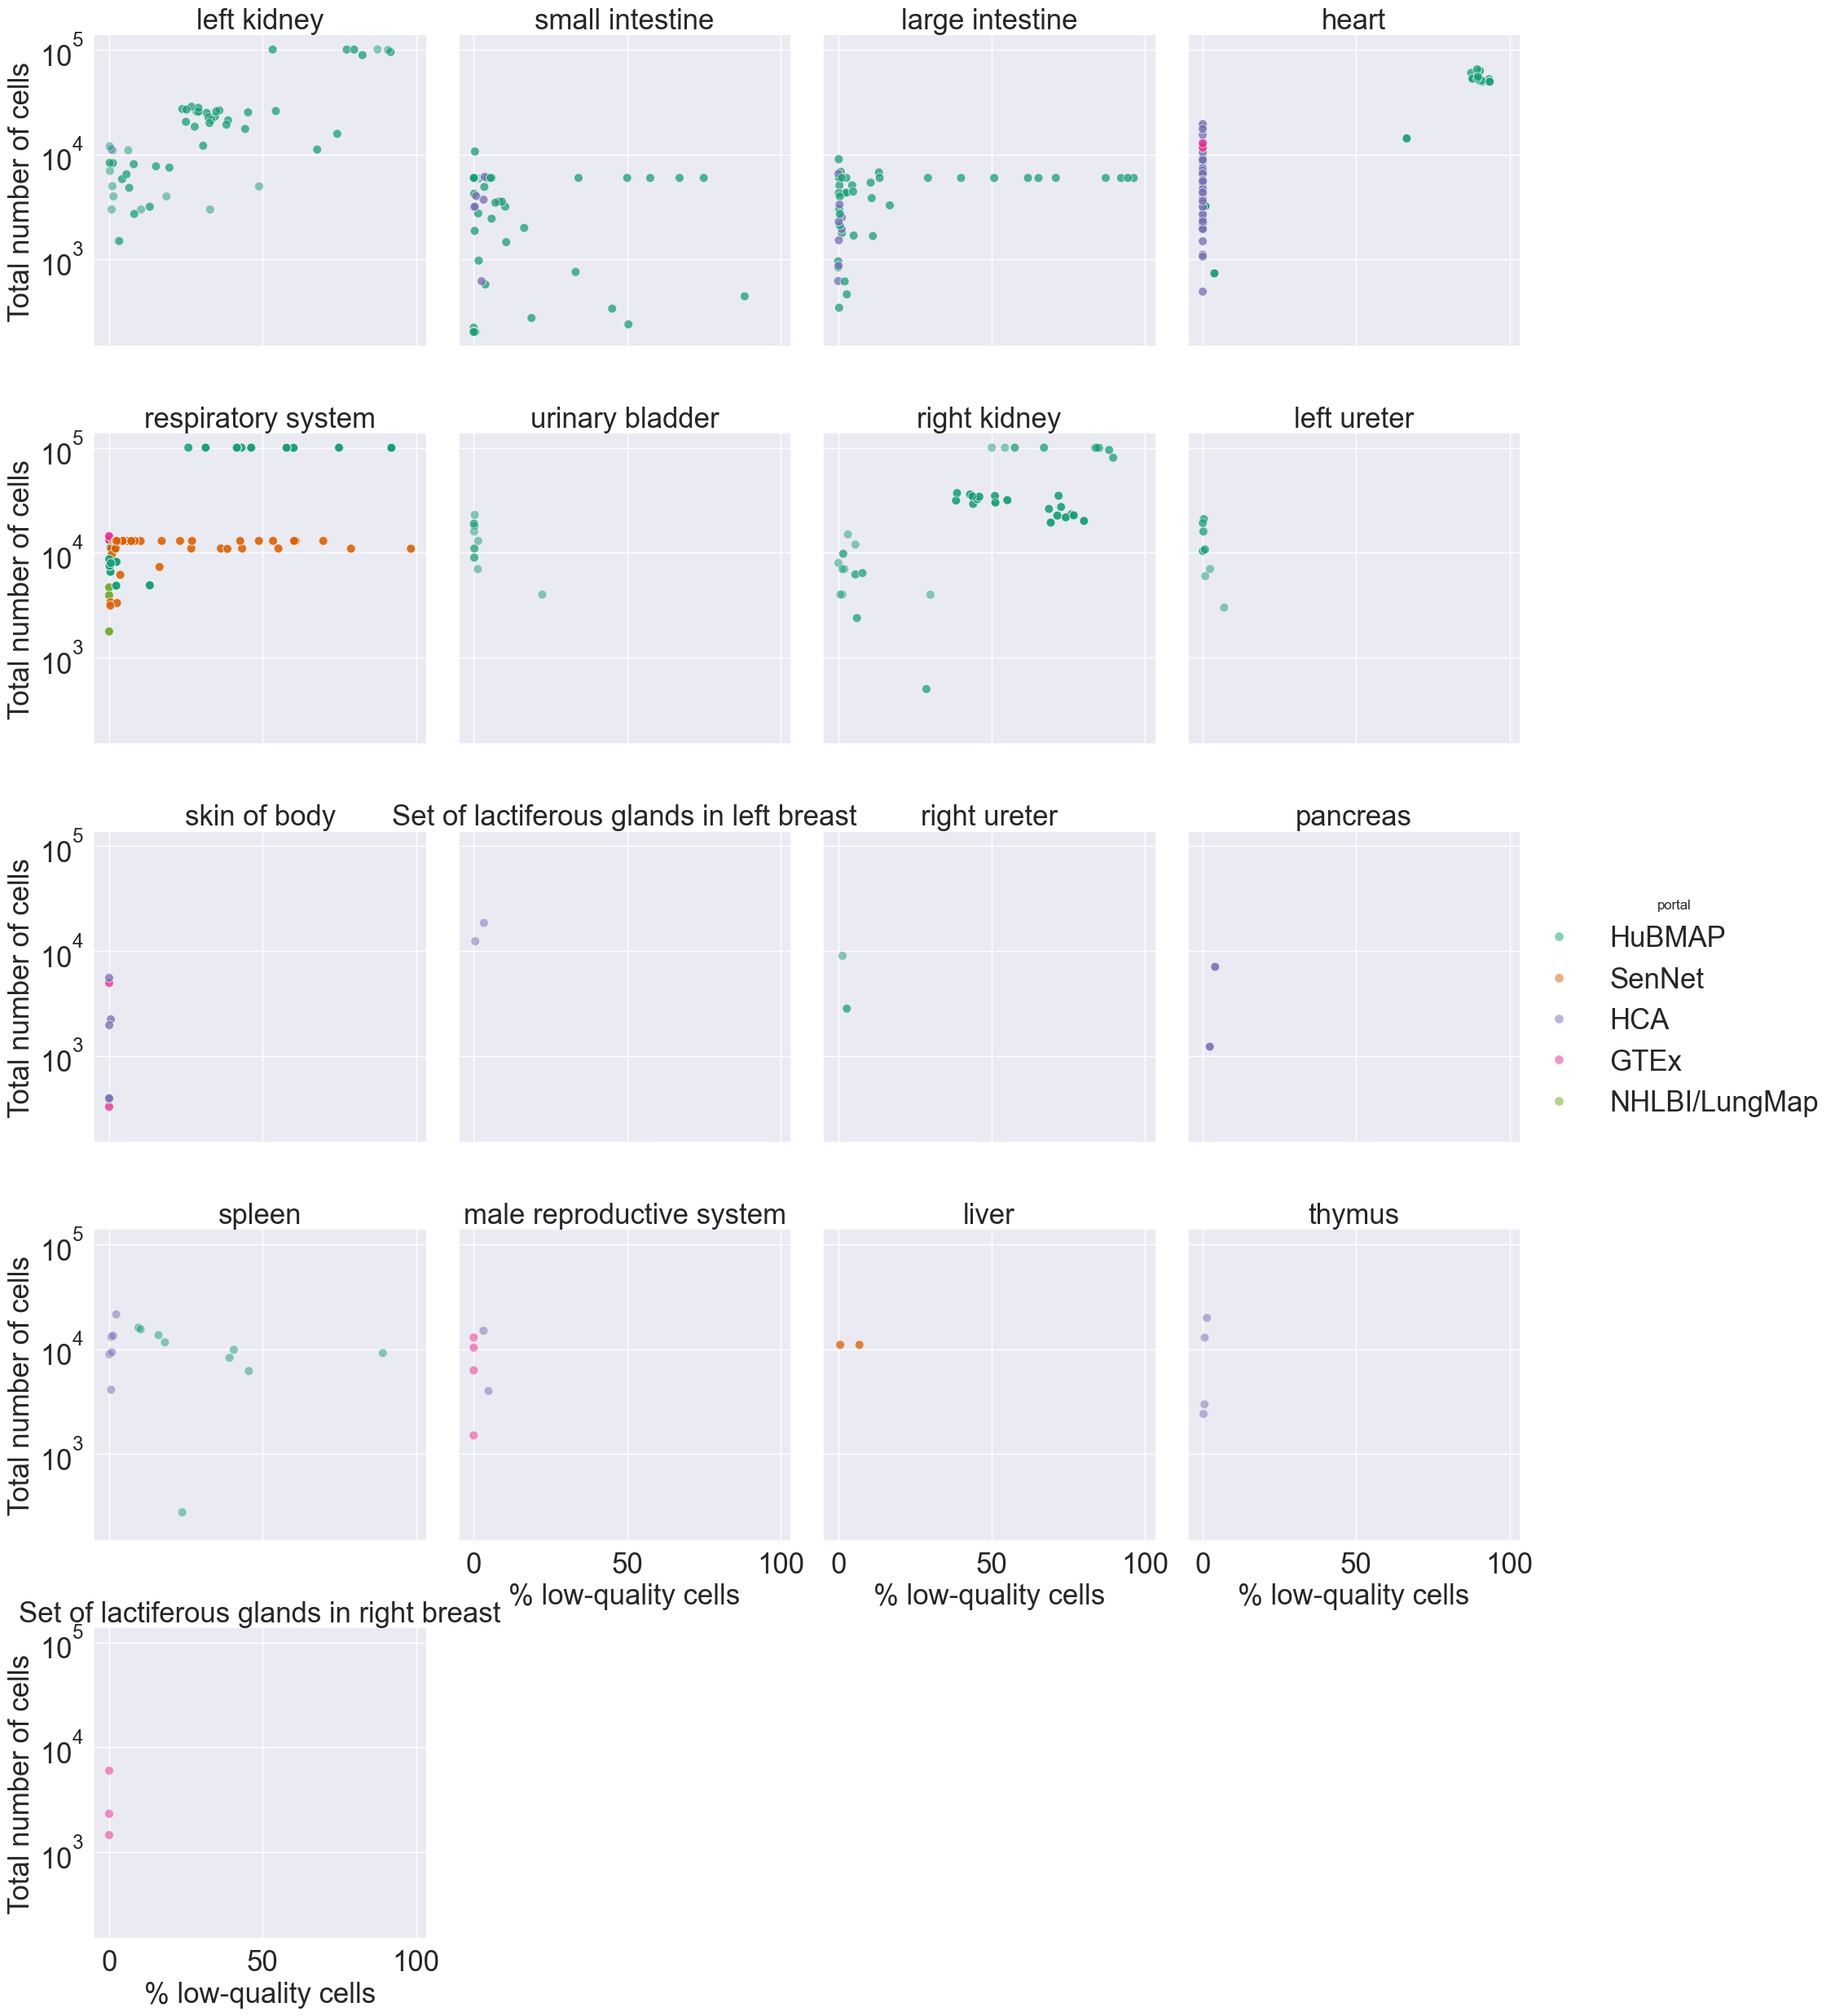

In [50]:
sns.set_theme(
    rc={
        "figure.figsize": (10, 6),
        "font.size": 15,
        "axes.titlesize": 25,
        "axes.labelsize": 25,
        "xtick.labelsize": 25,
        "ytick.labelsize": 25,
        "legend.fontsize": 25,
    },
)

# Facet the scatterplot by organ_name
g = sns.relplot(
    data=df_merged,
    x="percent_low_quality",
    y="total_cells",
    hue="portal",
    col="organ_name",  # facet each organ in its own subplot (column)
    col_wrap=4,  # wrap every 3 plots to a new row
    kind="scatter",
    s=60,
    alpha=.5,
    palette="Dark2"
)

plt.yscale("log")

# Label axes
g.set_axis_labels("% low-quality cells", "Total number of cells")
g.set_titles("{col_name}")

plt.show()